In [1]:
import vega

In [2]:
import glob
import os
import h5py

import altair as alt
import numpy as np
import pandas as pd
from vega_datasets import data

from sklearn.manifold import TSNE

In [3]:
import scipy.signal
import scipy.fftpack as fft

from librosa import cqt, magphase, note_to_hz, stft, resample, to_mono, load
from librosa import amplitude_to_db, get_duration, time_to_frames, power_to_db
from librosa.util import fix_length
from librosa.feature import melspectrogram, rmse, tempogram
from librosa.decompose import hpss
from librosa.onset import onset_strength

from librosa.filters import get_window
from librosa.core.audio import resample
from librosa import util

## Prepare data

In [4]:
data_dir = '../data'

In [5]:
h5 = h5py.File(os.path.join(data_dir, 'feats.h5'), 'r')
d = h5['features']

In [6]:
filenames_df = pd.read_csv(os.path.join(data_dir, 'filenames.csv'), index_col=0)

In [7]:
def get_audio_filenames(feat_files):
    return [os.path.splitext(os.path.basename(ff))[0] + '.wav' for ff in feat_files]

In [8]:
filenames_df['filename'] = get_audio_filenames(filenames_df['files'])
media_items_df = pd.read_csv('../data/media_items.csv', index_col=0)
media_items_df['filename'] = media_items_df['media_file'].apply(os.path.basename)
media_items_df['recorded_from_date'] = pd.to_datetime(media_items_df['recorded_from_date'])
media_items_df['recorded_to_date'] = pd.to_datetime(media_items_df['recorded_to_date'])
media_items_df.drop('decade', axis=1)
df = filenames_df.merge(media_items_df, how='inner', on='filename')

In [9]:
missing_latlongs = (('Hoggar', 23.2898, 5.5364),
                    ('Uttar Pradesh', 26.8467, 80.9462),
                    ('Koufra', 23.3112, 21.8569),
                    ('Mao', 14.12116, 15.3103),
                    ('Fezzan', 29.161137, 16.144485),
                    ('Baloutchistan', 28.4907, 65.0958),
                    ('Tibesti', 21.3650, 16.9123),
                    (np.nan,np.nan,np.nan),
                    ('Province de Mahajanga', -16.5239, 46.5163),
                    ('Assam', 26.2006, 92.9376 ),
                    ('Province de Toleara', -23.1485, 44.3993),
                    ('Kerala', 10.8505, 76.2711),
                    ('Kanem', 14.8781, 15.4068),
                    ('Aurès', 35.3201, 6.6465),
                    ('Abyssinie', 30.7328, 31.5570),
                    ('Région Harar', 9.3149, 42.1968),
                    ('Inde du Sud', 10.8505, 76.2711),
                    ('Trivandrum', 8.5241, 76.9366),
                    ('Asie centrale', 40.1431, 47.5769),
                    ('Java', -7.6145, 110.7122),
                    ('Aden', 12.7855, 45.0187),
                    ("Province d'Antsiranana", 13.7715, 49.5280),
                    ('Shkodra', 42.0693, 19.5033),
                    ('Damas', 33.5151, 36.3931),
                    ('Sarh', 9.1412, 18.3683),
                    ('Tunis', 33.8869, 9.5375),
                    ('Sanaa', 15.3694, 44.1910),
                    ('Toleara', -23.3516, 43.6855),
                    ('Kaboul', 34.5553, 69.2075),
                    ('Turkestan chinois', 42.5246, 87.5396),
                    ('Cochin', 9.9312, 76.2673),
                    ("N'Djamena", 12.1348, 15.0557),
                    ('Province de Téhéran', 35.7248, 51.3817),
                    ('Chittagong', 22.3569, 91.7832),
                    ('Madras', 13.0827, 80.2707),
                    ('Gjirokastre', 40.0673, 20.1045),
                    ('Mahajanga', -15.6921, 46.3337),
                    ('Inde du Nord', 28.7041, 77.1025),
                    ("Province d'Antananarivo", -18.7051, 46.8253),
                    ('Golfe Arabo-persique', 26.7505, 51.6834),
                    ("Émirat d'Abou Dhabi", 23.4677, 53.7369),
                    ('Bali', -8.3405, 115.0920),
                    ('Province de Fianarantsoa', -22.3536, 46.8253),
                    ('Marrakech', 31.6295, 7.9811),
                    ('Tirana', 41.3275, 19.8187),
                    ('Caucase', 43.5852, 45.0000),
                    ('Biskra', 34.8370, 5.7510),
                    ('Tamil Nadu', 11.1271, 78.6569),
                    ('Zanzibar', -6.1357, 39.3621),
                    ('Goudjerat', 22.2587, 71.1924),
                    ('Istanbul', 41.0082, 28.9784),
                    ('Lalibela', 12.0309, 39.0476),
                    ('Gambela', 8.2472, 34.5916),
                    ('Travancore', 10.8505, 76.2711),
                    ('Korçë', 40.6141, 20.7778),
                    ('Turkestan -- KAZ', 43.3667, 68.4094),)

In [10]:
for mll in missing_latlongs:
    if mll[0] is np.nan:
        continue
    df.loc[df['location']==mll[0],'location_lat'] = mll[1]
    df.loc[df['location']==mll[0],'location_long'] = mll[2]

In [11]:
onset_patterns_tsne_df = pd.read_csv(os.path.join(data_dir, 'onset_patterns_tsne.csv'), index_col=0)
df = df.merge(onset_patterns_tsne_df, how='inner', on='filename')

mean_power_spec_tsne_df = pd.read_csv(os.path.join(data_dir, 'mean_power_spec_tsne.csv'), index_col=0)
df = df.merge(mean_power_spec_tsne_df, how='inner', on='filename')

median_tempogram_ratio_tsne_df = pd.read_csv(os.path.join(data_dir, 'median_tempogram_ratio_tsne.csv'), index_col=0)
df = df.merge(median_tempogram_ratio_tsne_df, how='inner', on='filename')

median_filt_tempogram_tsne_df = pd.read_csv(os.path.join(data_dir, 'median_filt_tempogram_tsne.csv'), index_col=0)
df = df.merge(median_filt_tempogram_tsne_df, how='inner', on='filename')

In [12]:
estimated_tempo_df = pd.DataFrame(dict(filename=d['filename'].astype('str'),
                                       estimated_tempo=d['estimated_tempo']))
df = df.merge(estimated_tempo_df, how='inner', on='filename')

In [13]:
median_percussive_ratio_db_df = pd.DataFrame(dict(filename=d['filename'].astype('str'),
                                                  median_percussive_ratio_db=d['median_percussive_ratio_db']))
df = df.merge(median_percussive_ratio_db_df, how='inner', on='filename')

In [14]:
df['local_path'] = 'file://' + df['filename'].str.replace('.wav', '.mp3')

In [15]:
tr_text = []
for subd in ['32', '16', '8', '4', '2', '1']:
    for a in ['t', '', 'd']:
        tr_text.append(subd + a)
tr_text

median_tempogram_ratio_df = pd.DataFrame(dict([(tr_text[idx], d['median_tempogram_ratio'][:,idx]) for 
                                              idx in range(d['median_tempogram_ratio'].shape[1])]))
median_tempogram_ratio_df['filename'] = d['filename'].astype('str')

median_tempogram_ratio_df = median_tempogram_ratio_df.melt('filename', var_name='tr', value_name='energy')
median_tempogram_ratio_df = median_tempogram_ratio_df.merge(df[['media_item_id', 'filename']], how='inner', on='filename')

## Visualize data

In [16]:
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

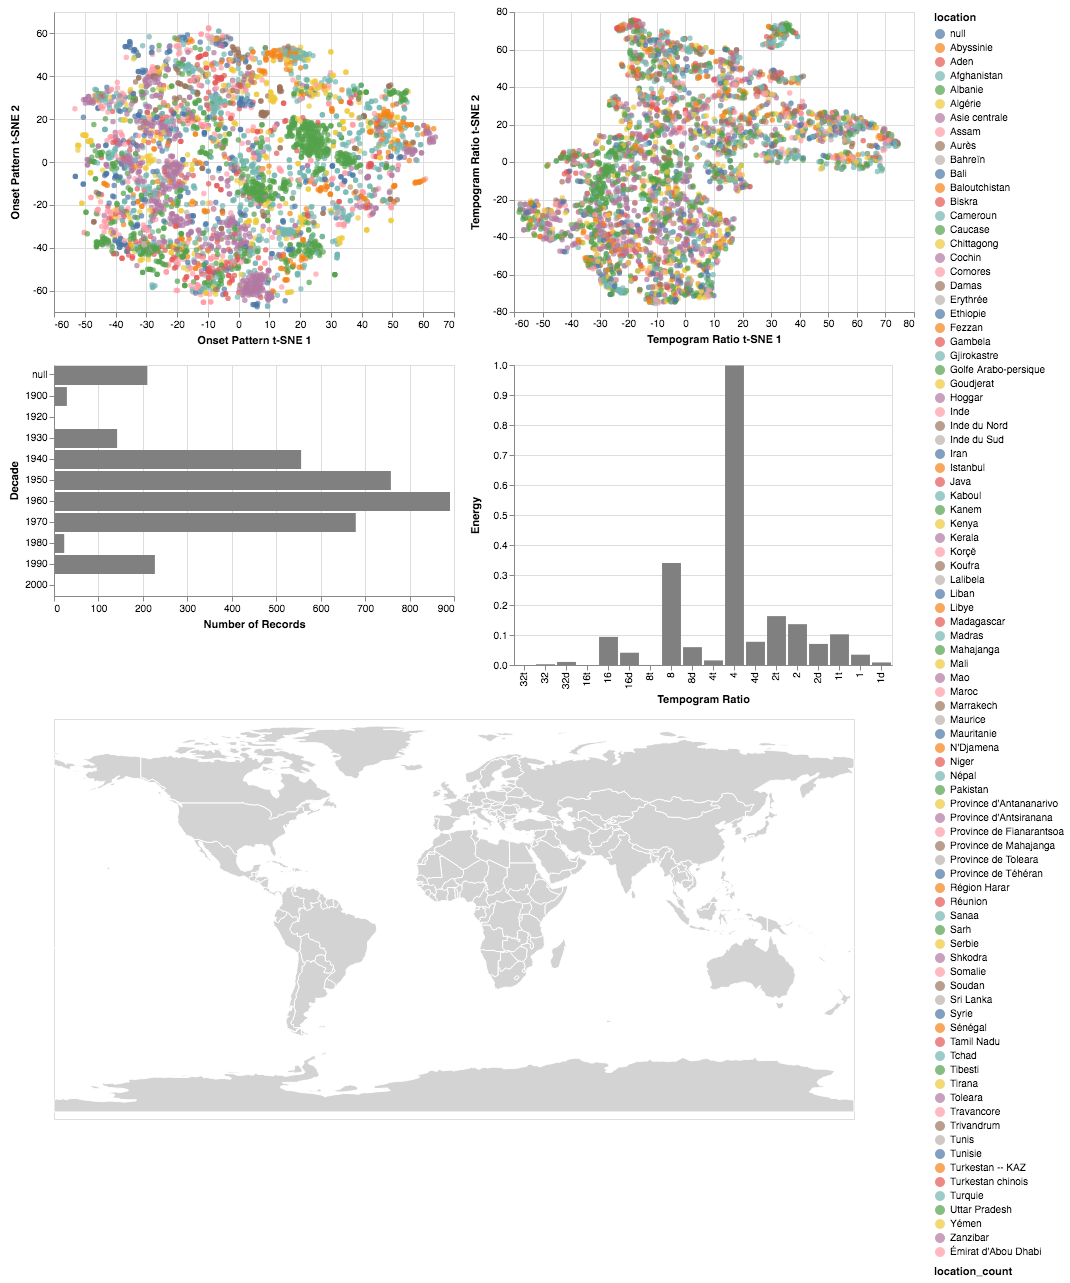

In [17]:
brush = alt.selection(type='interval', empty='none')

op_tsne = alt.Chart(df).mark_circle().encode(
    x=alt.X('onset_patterns_tsne1:Q', title='Onset Pattern t-SNE 1'),
    y=alt.Y('onset_patterns_tsne2:Q', title='Onset Pattern t-SNE 2'),
    color='location:N', #alt.condition(brush, 'location:N', alt.value('grey')),
    tooltip=['filename', 'location', 'ethnic_group', 'original_format', 'recorded_from_date', 'recording_context', ],
    href='local_path'
).add_selection(brush)


tr_tsne = alt.Chart(df).mark_circle().encode(
    x=alt.X('median_tempogram_ratio_tsne1:Q', title='Tempogram Ratio t-SNE 1'),
    y=alt.Y('median_tempogram_ratio_tsne2:Q', title='Tempogram Ratio t-SNE 2'),
    color='location:N',
    tooltip=['filename', 'location', 'ethnic_group', 'original_format', 'recorded_from_date', 'recording_context', 'local_path', ]
)

tr_tsne_highlight = tr_tsne.encode(
    color=alt.value('red')
).transform_filter(brush)


decade = alt.Chart(df).mark_bar().encode(
    y=alt.Y('decade:O', title='Decade'),
    color=alt.value('grey'),
    x='count(decade):O'
)

decade_highlight = decade.encode(
    color=alt.value('red')
).transform_filter(brush)


tr = alt.Chart(median_tempogram_ratio_df).mark_bar().encode(
    x=alt.X('tr:O', scale=alt.Scale(domain=tr_text), title='Tempogram Ratio'),
    color=alt.value('grey'),
    y=alt.Y('mean(energy):Q', scale=alt.Scale(domain=[0, 1]))
)

tr_highlight = alt.Chart(median_tempogram_ratio_df).mark_bar().encode(
    x=alt.X('tr:O', scale=alt.Scale(domain=tr_text), title='Tempogram Ratio'),
    color=alt.value('red'),
    y=alt.Y('mean(energy):Q',scale=alt.Scale(domain=[0, 1]), title='Energy')
).transform_lookup(lookup='media_item_id',
                   from_=alt.LookupData(data=df, key='media_item_id', 
                                        fields=['onset_patterns_tsne1', 'onset_patterns_tsne2']),
                   as_=['onset_patterns_tsne1', 'onset_patterns_tsne2']).transform_filter(brush)

countries = alt.topo_feature(data.world_110m.url, 'countries')
background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=400,
).project('equirectangular')

location = alt.Chart(df).mark_circle().encode(
    longitude=alt.Longitude('location_long:Q',),
    latitude=alt.Latitude('location_lat:Q',),
    color='location:N',
    size=alt.Size('location_count:Q', sort= "ascending", scale=alt.Scale(range=[5, 200]))
).transform_filter(brush).transform_aggregate(location_count='count():Q',
                                              location_long='mean(location_long)',
                                              location_lat='mean(location_lat)',
                                              groupby=['location'])

chart = (op_tsne | (tr_tsne + tr_tsne_highlight)) & ((decade + decade_highlight) | (tr + tr_highlight)) & (background + location)
chart.save('chart.html')
chart